<a href="https://colab.research.google.com/github/martostwo/Deep_Neural_Network_TimeSeries_Forecasting/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Module import

In [ ]:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

Dark mode for Graphics

In [ ]:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');

Pre-processing function for Forex data coming from MT5 (H4)

In [ ]:
def preprocessing(path):

    #Importar los datos:
    df = pd.read_csv(
        path,
        delimiter = "\t",
        index_col="<DATE>",
        parse_dates=True
    ).dropna();

    #Eliminar las últimas 3 columnas:
    df = df.iloc[:,:-3];

    #Renombrar:
    df.columns = ["open", "high", "low", "close"];
    df.index.name = "date";
    return df;

Function for feature engineering (H4)

In [ ]:
def feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

Data Preparation

In [ ]:
df = preprocessing("/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/EURUSD_Daily.csv");
df = feature(df);
df

,open,high,low,close,returns,SMA 15,SMA 60,MSD 15,MSD 60,rsi
date,,,,,,,,,,
2003-05-13,1.15660,1.15720,1.14620,1.15370,-0.002507,1.122260,1.090125,0.006362,0.006451,77.358678
2003-05-14,1.15380,1.15410,1.14670,1.14730,-0.005547,1.126007,1.091540,0.006325,0.006444,74.679804
2003-05-15,1.14730,1.14920,1.13690,1.13800,-0.008106,1.129467,1.092747,0.006605,0.006477,69.000900
2003-05-16,1.13820,1.15990,1.13690,1.15970,0.019069,1.131773,1.093680,0.007087,0.006543,61.662971
2003-05-19,1.16690,1.17430,1.16190,1.16480,0.004398,1.135507,1.095063,0.008301,0.006907,69.747305
...,...,...,...,...,...,...,...,...,...,...
2023-02-13,1.06813,1.07298,1.06553,1.07246,0.004355,1.082820,1.065319,0.005281,0.005151,42.169202
2023-02-14,1.07195,1.08047,1.07068,1.07355,0.001016,1.081842,1.066126,0.005432,0.005057,46.610077
2023-02-15,1.07369,1.07444,1.06604,1.06868,-0.004536,1.080825,1.066847,0.005417,0.005010,47.625364


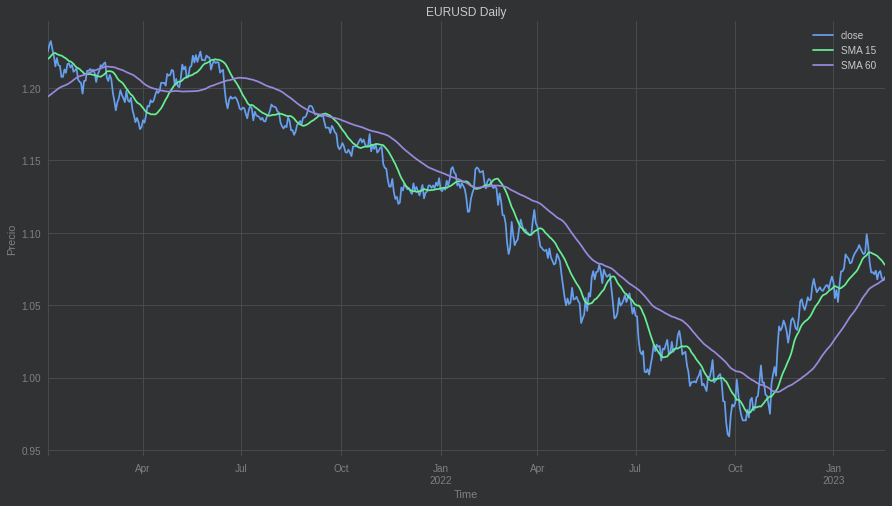

In [ ]:
df[["close","SMA 15", "SMA 60"]].loc["2021":].plot(figsize=(15,8));
plt.title("EURUSD Daily");
plt.xlabel("Time");
plt.ylabel("Precio");
plt.show();

Split training and testing data

In [ ]:
#Porcentaje del conjunto de entrenamiento:
split = int(0.85*len(df));

#Creación del conjunto de entrenamiento:
x_train = df[['SMA 15', 'SMA 60', 'MSD 15', 'MSD 60', 'rsi']].iloc[:split,:];
y_train = df[['returns']].iloc[:split,:];

#Creación del conjunto de testing:
x_test = df[['SMA 15', 'SMA 60', 'MSD 15', 'MSD 60', 'rsi']].iloc[split:,:];
y_test = df[['returns']].iloc[split:,:];

x_train

,SMA 15,SMA 60,MSD 15,MSD 60,rsi
date,,,,,
2003-05-13,1.122260,1.090125,0.006362,0.006451,77.358678
2003-05-14,1.126007,1.091540,0.006325,0.006444,74.679804
2003-05-15,1.129467,1.092747,0.006605,0.006477,69.000900
2003-05-16,1.131773,1.093680,0.007087,0.006543,61.662971
2003-05-19,1.135507,1.095063,0.008301,0.006907,69.747305
...,...,...,...,...,...
2020-02-26,1.087203,1.104524,0.002834,0.002734,42.073416
2020-02-27,1.086412,1.104193,0.002701,0.002637,42.008479
2020-02-28,1.086541,1.104061,0.004041,0.003015,58.545278


Standardization

Estandarización de los datos para conseguir la
independencia de escala. De esta forma la red no
ortogará más importancia a unas características que a otras solo
por su orden de magnitud y será capaz de encontrar
patrones más fácilmente


In [ ]:
#Standardization
from sklearn.preprocessing import StandardScaler;

sc = StandardScaler();

#Estandarizamos conjunto de entrenamiento:
x_train_sc = sc.fit_transform(x_train);

#Estandarizamos conjunto de testing:
x_test_sc = sc.transform(x_test);

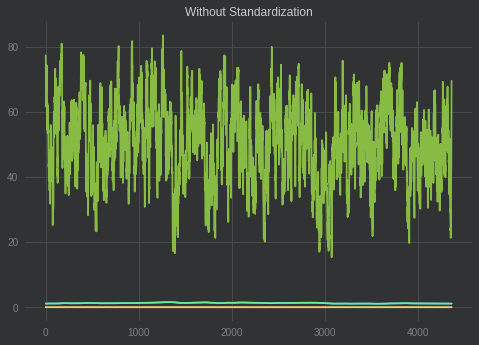

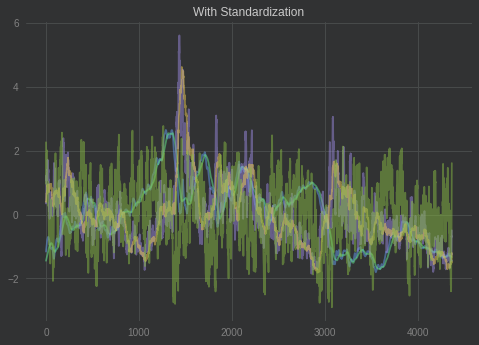

In [ ]:
#Graficamos los datos con y sin standarización para
#ver la diferencia de escala y cómo queda trás el proceso:

plt.plot(x_train.values);
plt.title("Without Standardization");
plt.show();

plt.plot(x_train_sc, alpha=0.5);
plt.title("With Standardization");
plt.show();


Deep Neural Network (DNN)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Librerías
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


# Inicialización del modelo secuencial
model = Sequential()

# La primera capa
model.add(Dense(500, input_shape=(x_train_sc.shape[1],), activation="relu"))
model.add(Dropout(0.25))

# Aadimos las capas ocultas
for i in range(1,nb_hidden_layer):
  model.add(Dense(int(125/i), activation="relu"))


# La capa densa de salida
model.add(Dense(1, activation="linear"))

# Compilamos el modelo
model.compile(loss="mse", optimizer="adam")

early_stop = EarlyStopping(verbose=1, patience = 10)

model.fit(x_train_sc, y_train, validation_data=(x_test_sc, y_test), epochs=200, callbacks=[early_stop])


Epoch 1/200
137/137 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 5.2185e-04
Epoch 2/200
137/137 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 8.4049e-04
Epoch 3/200
137/137 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 5.1321e-05
Epoch 4/200
137/137 [==============================] - 0s 3ms/step - loss: 7.3469e-04 - val_loss: 1.1108e-04
Epoch 5/200
137/137 [==============================] - 0s 3ms/step - loss: 4.4244e-04 - val_loss: 1.0333e-04
Epoch 6/200
137/137 [==============================] - 0s 3ms/step - loss: 2.8310e-04 - val_loss: 4.4112e-05
Epoch 7/200
137/137 [==============================] - 0s 3ms/step - loss: 2.0350e-04 - val_loss: 3.4805e-05
Epoch 8/200
137/137 [==============================] - 0s 3ms/step - loss: 1.6608e-04 - val_loss: 4.6833e-05
Epoch 9/200
137/137 [==============================] - 0s 3ms/step - loss: 1.2014e-04 - val_loss: 4.6291e-05
Epoch 10/200
137/137 [=========

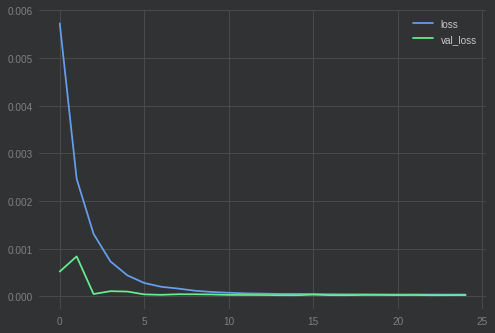

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
#Creamos predicciones para los datos con los
#que no ha sido entrenada la red neuronal (x_test_sc)
df["prediction"] = model.predict(np.concatenate((x_train_sc,x_test_sc),axis=0));

#Calculamos la estrategia:
df["strategy"] = df["returns"]*np.sign(df["prediction"].shift(1));

161/161 [==============================] - 0s 2ms/step


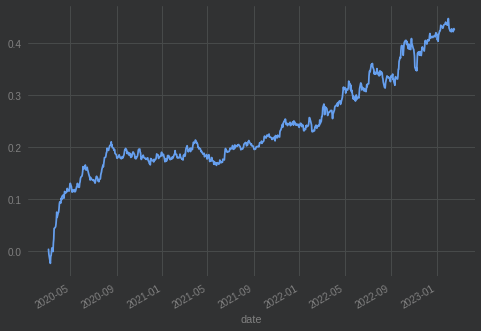

date
2003-05-13   -0.000420
2003-05-14    0.000345
2003-05-15    0.000194
2003-05-16    0.000492
2003-05-19   -0.000806
                ...   
2023-02-13   -0.002462
2023-02-14   -0.002102
2023-02-15   -0.002078
2023-02-16   -0.002683
2023-02-17   -0.002726
Name: prediction, Length: 5138, dtype: float32

In [ ]:
df["strategy"].iloc[split:].cumsum().plot();
plt.show(); 
df["prediction"]

Automatization